Sample workflow: 
Select 4-band [NAIP](https://en.wikipedia.org/wiki/National_Agriculture_Imagery_Program) images from [Descarteslabs API](https://docs.descarteslabs.com/quickstart.html) and pass to [Microsoft AI for Earth API](https://aiforearth.portal.azure-api.net/docs/services/) for land cover classification.

## Scenes:

In [1]:
import numpy as np
import descarteslabs as dl

/home/jthoms/anaconda3/envs/descarteslabs/lib/python3.7/site-packages/geojson/mapping.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping


In [2]:
from shapely.geometry import Polygon
from shapely import affinity
from PIL import Image
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
# Sample polygon
aoi_geometry = Polygon([(-120.22527694702146,36.84308698031286),
                        (-120.09653091430661,36.84308698031286),
                        (-120.09653091430661,36.939190592188325),
                        (-120.22527694702146,36.939190592188325),
                        (-120.22527694702146,36.84308698031286)])
# Scale down
aoi_geometry = affinity.scale(aoi_geometry, xfact=.1, yfact=.1, origin='center')
# Descarteslabs scenes from National Agriculture Imagery Program v1, 2012-01-01 to 2018-01-01
scenes_v1, ctx_v1 = dl.scenes.search(aoi_geometry,
                               products=["usda:naip:rgbn:v1"],
                               start_datetime="2012-01-01",
                               end_datetime="2018-01-01",
                               limit=10)
# usda:naip:rgbn (deprecated), 2008-01-01 to 2016-01-01
scenes_v0, ctx_v0 = dl.scenes.search(aoi_geometry,
                               products=["usda:naip:rgbn"],
                               start_datetime="2008-01-01",
                               end_datetime="2016-01-01",
                               limit=10)
print(scenes_v1)
print(scenes_v0)

SceneCollection of 3 scenes
  * Dates: Jun 22, 2012 to Jun 21, 2016
  * Products: usda:naip:rgbn:v1: 3
SceneCollection of 2 scenes
  * Dates: Jun 22, 2012 to Jun 22, 2014
  * Products: usda:naip:rgbn: 2


Scene "usda:naip:rgbn:v1:meta_m_3612007_se_10_h_20160621_v1"
  * Product: "usda:naip:rgbn:v1"
  * CRS: "EPSG:26910"
  * Date: Tue Jun 21 00:00:00 2016
  * Bands:
    * derived:bai: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:evi: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:ndvi: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:rsqrt: Float64, [0, 1000] -> [0.0, 1.0]
    * derived:visual_cloud_mask: UInt16, [0, 1] -> None
    * blue: 1 meters, Byte, [0, 255] -> [0.0, 1.0]
    * green: 1 meters, Byte, [0, 255] -> [0.0, 1.0]
    * nir: 1 meters, Byte, [0, 255] -> [0.0, 1.0]
    * red: 1 meters, Byte, [0, 255] -> [0.0, 1.0]


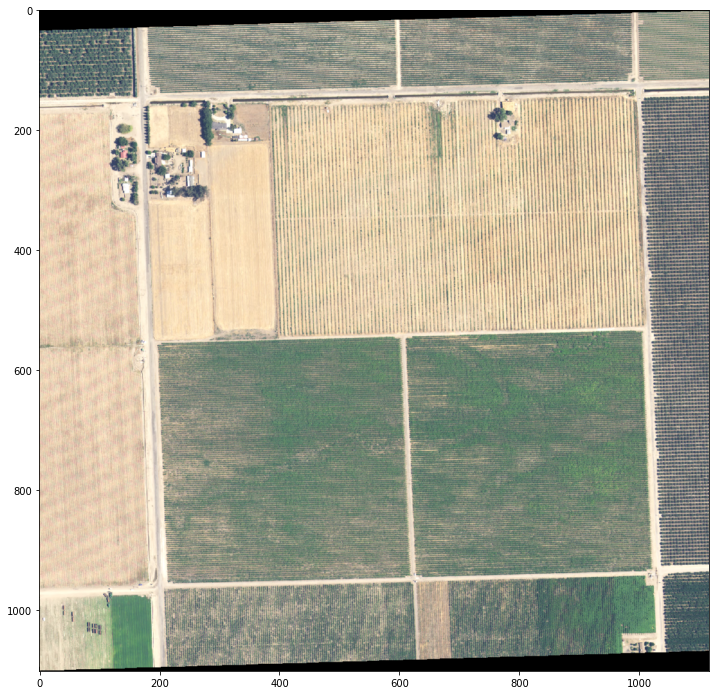

In [4]:
# Select and display a scene from v1 dataset
scenes_v1 = scenes_v1.sorted("properties.date")
scene = scenes_v1[-1]
print(scene)

ctx_res = ctx_v1.assign(resolution=1)
arr = scene.ndarray("red green blue", ctx_res)
dl.scenes.display(arr)

In [5]:

def make_square(img, max_size=1000, fill_color=(0, 0, 0, 0)):
    x, y = img.size
    size = min(max_size, x, y)
    img_new = Image.new('RGBA', (size, size), fill_color)
    img_new.paste(img, ((size - x) // 2, (size - y) // 2))
    return img_new

(1000, 1000)


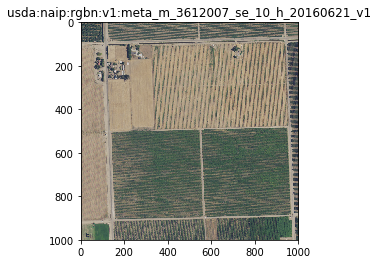

In [6]:
img_path_dl = "./images/{ctx.resolution}-{scene.properties.id}-red-green-blue-nir-{version}.tif".format(ctx=ctx_res, scene=scene, version="dl")
scene.download("red green blue nir", ctx_res, dest=img_path_dl)
img_dl = Image.open(img_path_dl)
img_dl.load()

# MS API accepts square image, size <= 4M
img_sq = make_square(img_dl)
print(img_sq.size)
img_path_sq = "./images/{ctx.resolution}-{scene.properties.id}-red-green-blue-nir-{version}.tif".format(ctx=ctx_res, scene=scene, version="sq")
img_sq.save(img_path_sq)
img_arr_sq = np.asarray(img_sq)
plt.title(scene.properties.id);
plt.imshow(img_arr_sq)
plt.show()

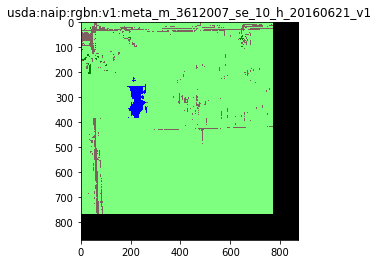

In [7]:
import http.client, urllib.parse, os

headers = {
    # Request headers
    'Content-Type': 'image/tiff',
    'Ocp-Apim-Subscription-Key': os.environ["MS_API4EARTH_KEY"],
}
params = urllib.parse.urlencode({
    # Request parameters
    'type': 'tiff',
})

img_path_ms = "./images/{ctx.resolution}-{scene.properties.id}-red-green-blue-nir-{version}.tif".format(ctx=ctx_res, scene=scene, version="ms")

try:
    conn = http.client.HTTPSConnection('aiforearth.azure-api.net')
    conn.request("POST", "/v0.1/landcover/classify?%s" % params, open(img_path_sq, 'rb'), headers)
    response = conn.getresponse()
    data = response.read()
    if response.status == 200:
        out = open(img_path_ms, 'wb')
        out.write(data)
        out.close()
        img_ms = Image.open(img_path_ms)
        img_arr_ms = np.asarray(img_ms)
        plt.title(scene.properties.id);
        plt.imshow(img_arr_ms)
        plt.show()
    else:
        print(data)
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))